In [202]:
import numpy as np 
from math import cos
from scipy.interpolate import LinearNDInterpolator
from tqdm.notebook import trange, tqdm
from scipy.optimize import basinhopping
from skimage.feature import match_template
from sklearn.metrics import mean_squared_error
from scipy.ndimage.interpolation import shift
from sklearn.metrics import mutual_info_score
import random
from numpy import linalg as LA
import imageio
from PIL import ImageChops
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import scipy.spatial.distance as dist
from numpy import asarray
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
from scipy.ndimage.interpolation import shift
from skimage import data, img_as_float
from scipy.optimize import differential_evolution
from sklearn import preprocessing
import scipy.ndimage as snd
import h5py
import sklearn.feature_selection as sk
from sklearn.feature_selection import mutual_info_classif as MIC
import time
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage import img_as_ubyte, img_as_float
from skimage.exposure import histogram, cumulative_distribution
from scipy.optimize import fmin_powell
from scipy.optimize import dual_annealing
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
np.set_printoptions(precision=5,suppress=True)



(2093, 160, 160)
(2093, 160, 160)


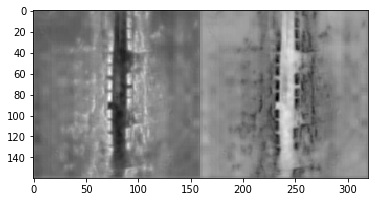

In [203]:
path_Semseg = 'C:/Users/bjqb7h/Downloads/Thesis2022/SEMSEGGPS'
log  = '/AtCityBMW_Applanix-20220601T115459Z469'
semsegpath ='C:/Users/bjqb7h/Downloads/Thesis2022/semsegimage'
path_GPS = 'C:/Users/bjqb7h/Downloads/Thesis2022/NUMPY/New/'
log_GPS  = 'AtCityBMW_Applanix-20220601T115459Z469DGPSWNS3'
log_DGPS = 'AtCityBMW_Applanix-20220601T115459Z469CalibDGPS'

h5f = h5py.File(path_Semseg +log+'.h5','r')
dset = h5f.get('grid_prediction')

GPS = h5py.File(path_GPS+log_GPS+'.hdf5','r')
GPSDSET = GPS.get(log+'/Image data')

#Importing DGPS MAPS
h5fDGPS = h5py.File(path_GPS+log_DGPS+'.hdf5','r')
dset5 = h5fDGPS.get(log+'/Image data')

A=len(dset5)
SemsegData = np.reshape(dset,(A,160,160,2))
FreeData = SemsegData[:,:,:,0]
OccupiedData=SemsegData[:,:,:,1]

print(FreeData.shape)
print(OccupiedData.shape)
plt.imshow(np.hstack((OccupiedData[10],FreeData[10])))

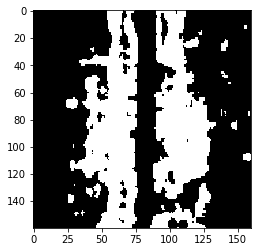

In [107]:
T=random.randint(0,2093)


#USING GPS HDF5 dATASET
t1_slice = GPSDSET[T,:,:,1]
# t1_set = np.flip(dset5[:,:,:,1],axis=1)
t1_slice = np.flip(t1_slice, axis=1)
GPS_data = t1_slice

#Using SEMSEG HDF5 DIRECTLY
semseg_merged = np.argmax(SemsegData, axis=-1)

t2_set = np.rot90(SemsegData[T,:,:,0],2)
t2_slice_FREE = np.rot90(SemsegData[T,:,:,0],2)
t2_slice_FREE = asarray(t2_slice_FREE,dtype=np.float64)
t2_slice_occ = np.rot90(SemsegData[T,:,:,1],2)
t2_slice_occ = asarray(t2_slice_occ,dtype=np.float64)
Semseg_data = t2_slice_FREE


# #DGPS values
t3_slice = dset5[T,:,:,1]
t3_slice = np.flip(t3_slice, axis=1)
DGPS_data = t3_slice


GPS_data = GPS_data/GPS_data.max()
Semseg_data = Semseg_data/Semseg_data.max()
DGPS_data= DGPS_data/DGPS_data.max()

t2_slice_FREE = t2_slice_FREE/t2_slice_FREE.max()
t2_slice_occ= t2_slice_occ/t2_slice_occ.max()


# plt.imshow(np.hstack((t2_slice_FREE,t2_slice_occ,GPS_data)))
plt.imshow(semseg_merged[10])

In [6]:
import numpy as np

# Define threshold ranges for free and occupied channels
FREE_THRESHOLD_RANGE = (-0.971 , 1.5)
OCCUPIED_THRESHOLD_RANGE = (-1.223 , 0.84 )



# Reshape prediction array to (num_frames, rows, cols, num_channels)
prediction_data_reshaped = np.reshape(dset, (2093, 160, 160, 2))

# Create empty image array
image_data = np.zeros((2093, 160, 160, 3), dtype=np.uint8)

# Define colors
FREE_COLOR = (0, 0, 0)
OCCUPIED_COLOR = (255, 255, 255)


# Loop through each pixel in each frame and classify as free, occupied or uncertain
for frame_idx in range(2093):
    for row_idx in range(160):
        for col_idx in range(160):
            free_prob = prediction_data_reshaped[frame_idx, row_idx, col_idx, 0]
            occupied_prob = prediction_data_reshaped[frame_idx, row_idx, col_idx, 1]
            # Check if the pixel is a white car (occupied pixel) on a black road (free pixel)
            if free_prob < FREE_THRESHOLD_RANGE[0] and occupied_prob > OCCUPIED_THRESHOLD_RANGE[1]:
                # Set the pixel to black color to match the color of the road
                image_data[frame_idx, row_idx, col_idx] = FREE_COLOR
            # Use threshold range to classify other pixels
            elif occupied_prob > OCCUPIED_THRESHOLD_RANGE[1]:
                image_data[frame_idx, row_idx, col_idx] = OCCUPIED_COLOR
            elif free_prob < FREE_THRESHOLD_RANGE[0]:
                image_data[frame_idx, row_idx, col_idx] = FREE_COLOR
            elif free_prob > FREE_THRESHOLD_RANGE[1]:
                image_data[frame_idx, row_idx, col_idx] = FREE_COLOR
            elif occupied_prob < OCCUPIED_THRESHOLD_RANGE[0]:
                image_data[frame_idx, row_idx, col_idx] = FREE_COLOR
            else:
                # Otherwise, set pixel to gray color to represent uncertainty
                gray_value = int(255 * (free_prob + 18) / 36)
                gray_color = (gray_value, gray_value, gray_value)
                image_data[frame_idx, row_idx, col_idx] = gray_color

            
            

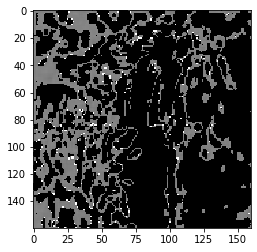

In [7]:
T1=image_data[T,:,:,0]
T1=np.rot90(T1,2)
plt.imshow(T1)

In [8]:
hDF5_PATH = r'C:\Users\bjqb7h\Downloads\Thesis2022\Semseg Images'
with h5py.File(hDF5_PATH+'/'+ log+'Semseg'+'.hdf5', 'w') as hf:
        grp = hf.create_group(log)
        dataset = grp.create_dataset('Image data', data=image_data) 

In [9]:
# Create empty image array
image_data1 = np.zeros((2093, 160, 160,3), dtype=np.float64)
# Loop through each pixel in each frame and classify as free, occupied or uncertain
for frame_idx in range(2093):
    for row_idx in range(160):
        for col_idx in range(160):
            free_prob = prediction_data_reshaped[frame_idx, row_idx, col_idx, 0]
            occupied_prob = prediction_data_reshaped[frame_idx, row_idx, col_idx, 1]
#             if free_prob > 0.87 and occupied_prob < OCCUPIED_THRESHOLD_RANGE[0]:
            if free_prob > 0.01 and occupied_prob < -0.01:
                image_data1[frame_idx, row_idx, col_idx] = FREE_COLOR
            elif free_prob < 0.01 and occupied_prob > -0.01:
                image_data1[frame_idx, row_idx, col_idx] = OCCUPIED_COLOR
            else:
                image_data1[frame_idx, row_idx, col_idx] = gray_color
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


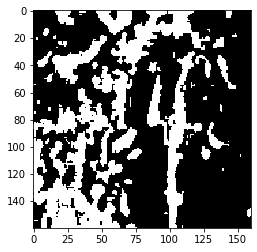

In [10]:
T2=image_data1[T,:,:,]
T2=np.rot90(T2,2)
plt.imshow(T2)

In [12]:


# Define the colors for the classes
FREE_COLOR =[255,255,255]  # Black
OCCUPIED_COLOR = [0, 0, 0]   # White
UNKNOWN_COLOR = [128, 128, 128]   # Grey

# Define the number of beams and their angles
NUM_BEAMS = 16
BEAM_ANGLES = np.linspace(0, 2*np.pi, NUM_BEAMS, endpoint=False)

# # Define a function to traverse the beams and color the pixels
# def traverse_beams(image, origin, beam_length):
#     for angle in BEAM_ANGLES:
#         dx = beam_length * np.cos(angle)
#         dy = beam_length * np.sin(angle)
#         endpoint = np.array([origin[0] + dx, origin[1] + dy], dtype=int)
#         cv2.line(image, tuple(origin[::-1]), tuple(endpoint[::-1]), FREE_COLOR, 1)
        
# Load the prediction data and reshape it
prediction_data_reshaped = SemsegData


# Create a new array for the output
output_data = np.zeros((2093, 160, 160, 3), dtype=np.uint8)

# Traverse the frames and process each one
for i in range(prediction_data_reshaped.shape[0]):
    frame = prediction_data_reshaped[i]
    normalized_frame = (frame - frame.min(axis=(0, 1))) / (frame.max(axis=(0, 1)) - frame.min(axis=(0, 1)))
    # Create a new image and assign classes based on the threshold values
    image = np.zeros((160, 160, 3), dtype=np.float64)
    black_mask = (normalized_frame[..., 1] > 0.500 )#&(normalized_frame[..., 0] < 0.550)  
    grey_mask = (normalized_frame[..., 0] > 0.600) & (normalized_frame[..., 0] < 0.650) #& (normalized_frame[..., 1] < 0.400 )& (normalized_frame[..., 1] > 0.299 )
    white_mask = (normalized_frame[..., 0] > 0.701) & (normalized_frame[..., 1] < 0.300 )
    image[black_mask] = FREE_COLOR
    image[grey_mask] = UNKNOWN_COLOR
    image[white_mask] = OCCUPIED_COLOR
    

    # Add the image to the output array
    output_data[i] = image

        


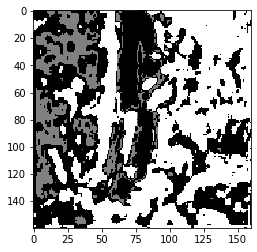

In [13]:
plt.imshow(output_data[T])

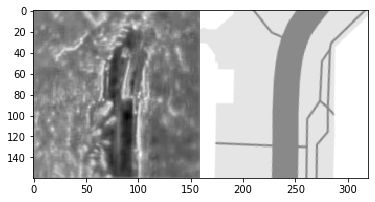

In [14]:
plt.imshow(np.hstack((t2_slice_occ,DGPS_data)))

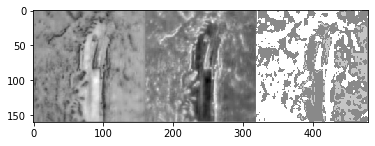

In [15]:
T6=output_data[T,:,:,0]
T6=np.rot90(T6,2)
T6= T6/T6.max()
plt.imshow(np.hstack((t2_slice_FREE,t2_slice_occ,T6)))

In [17]:
hDF5_PATH = r'C:\Users\bjqb7h\Downloads\Thesis2022\Semseg Images'
with h5py.File(hDF5_PATH+'/'+ log+'SemsegV1'+'.hdf5', 'w') as hf:
        grp = hf.create_group(log)
        dataset = grp.create_dataset('Image data', data=output_data) 

(160, 160)
(160, 160)
-3.1353034283370858 3.1353034283370858
51.50908839472167
1.7788849841171017
(160, 160) (7344,) (7344,)


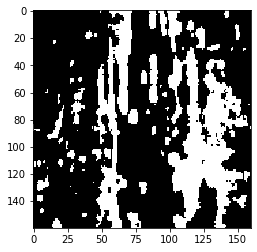

In [204]:
xrange=np.linspace(-40,40,160)
yrange=xrange

x, y = np.meshgrid(xrange,yrange)
theta=np.arctan2(y,x)
points = np.concatenate((x[..., np.newaxis], y[..., np.newaxis]), axis=-1)
r = np.linalg.norm(points,2,axis=-1)
#r = np.linalg.norm(np.concatenate((x, y), axis=1))
print(r.shape)
print(theta.shape)
frames =2093
for fr in range(frames):
    semseg_out= SemsegData[fr]
    dominent_class=np.argmax(semseg_out,axis=-1)
    occupied_class=dominent_class==1
    
    theta_occupied_class= theta[occupied_class]
    range_occupied_Class= r[occupied_class]
    
    
print(theta.min(),theta.max())
print(range_occupied_Class.max())
print(range_occupied_Class.min())
#plt.imshow(occupied_class)
plt.imshow(dominent_class)
print(occupied_class.shape,range_occupied_Class.shape,theta_occupied_class.shape)

In [205]:
def polar_projector(theta,rangevalue,occupied_class):
    theta_resolution = np.pi / 180
    theta_space = np.linspace(-np.pi, np.pi, 360)
    range_resol = 0.1
    range_extend = 40 * np.sqrt(2)
    range_bin_size = np.ceil(range_extend / range_resol)
    polar_array = np.zeros((range_bin_size.astype(int), theta_space.size))
    
    
     # Calculate the theta and range indices using the occupied indices
    theta_ind = np.floor(theta[occupied_class] / theta_resolution).astype(int)
    range_ind = np.floor(rangevalue[occupied_class] / range_resol).astype(int)
    
    
    polar_array[theta_ind,range_ind] = 1
    
    # Find the closest occupied range bin for each beam
    closest_occupied_range_bin = np.argmax(polar_array== 1, axis=0)
    actual_range_occ = closest_occupied_range_bin * range_resol

    return actual_range_occ

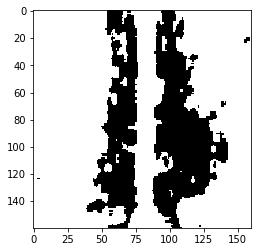

In [206]:
# theta_new = np.tile(theta, (actual_range.shape[0], 1))
semseg_out= SemsegData[1]
dominent_class=np.argmax(semseg_out,axis=-1)
occupied_class=dominent_class== 1
free_class = dominent_class == 0

# plt.imshow(np.hstack((free_class,occupied_class,unknown_class)))
plt.imshow(free_class)

In [207]:
import numpy as np
import matplotlib.pyplot as plt

# define x and y meshgrid
x,y = np.meshgrid(np.linspace(-40,40,160), np.linspace(-40,40,160))

# convert x and y to polar coordinates
theta = np.arctan2(y,x)
r = np.linalg.norm(np.concatenate((x[..., np.newaxis], y[..., np.newaxis]), axis=-1),2,axis=-1)
print(r.shape)

(160, 160)


In [208]:
def polar_projector_occ(theta, rangevalue, occupied_class):
    theta_resolution = np.pi / 180
    theta_space = np.linspace(-np.pi, np.pi, 360)
    range_resol = 0.1
    range_extend = 40 * np.sqrt(2)
    range_bin_size = np.ceil(range_extend / range_resol)
    polar_array = np.zeros((range_bin_size.astype(int), theta_space.size))

    # Calculate the theta and range indices using the occupied indices
    theta_ind = np.floor(theta[occupied_class] / theta_resolution).astype(int)
    range_ind = np.floor(rangevalue[occupied_class] / range_resol).astype(int)

    # Set the polar array values for the occupied class
    polar_array[range_ind, theta_ind] = 1

    # Find the closest occupied range bin for each beam
    closest_occupied_range_bin = np.argmax(polar_array== 1, axis=0)
    actual_range_occ = closest_occupied_range_bin * range_resol

    return actual_range_occ


def polar_projector_free(theta, rangevalue, free_class):
    theta_resolution = np.pi / 180
    theta_space = np.linspace(-np.pi, np.pi, 360)
    range_resol = 0.1
    range_extend = 40 * np.sqrt(2)
    range_bin_size = np.ceil(range_extend / range_resol)
    polar_array = np.zeros((range_bin_size.astype(int), theta_space.size))

    # Calculate the theta and range indices using the occupied indices
    theta_ind = np.floor(theta[free_class] / theta_resolution).astype(int)
    range_ind = np.floor(rangevalue[free_class] / range_resol).astype(int)

    # Set the polar array values for the occupied class
    polar_array[range_ind, theta_ind] = 1

#     # Find the closest free range bin for each beam
#     closest_free_range_bin = np.argmax(polar_array ==- 1, axis=0)
#     actual_range_free = closest_free_range_bin * range_resol

    return polar_array

In [209]:
frames =2093
actual_range_occ=np.zeros((2093,360))
actual_range_free = np.zeros((2093,566,360))


for fr in range(frames):
    semseg_out= SemsegData[fr]
    dominent_class=np.argmax(semseg_out,axis=-1)
    free_class = dominent_class == 1
    actual_range_free[fr,:] = polar_projector_free(theta, r, free_class)

In [210]:

num_range_bins = 566
num_theta_bins = 360
# Find the index of the maximum value in each column of the array
max_values = np.amax(actual_range_free, axis=1)

for i in range(num_theta_bins):
    max_column = max_values[:, i]
    if np.all(max_column == 0):
        continue  # skip this column if all values are zero
    for j in range(2093):
        max_value = max_column[j]
        if max_value == 0:
            continue  # skip this frame if max value is zero
        max_index = np.argmax(actual_range_free[j, :, i])
        actual_range_free[j, max_index+1:, i] = 0.5

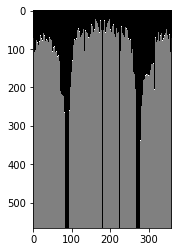

In [213]:
plt.imshow(actual_range_free[1])

In [214]:
free_class=np.zeros((2093,160,160))


for fr in range(frames):
    semseg_out= SemsegData[fr]
    dominent_class=np.argmax(semseg_out,axis=-1)
    occupied_class=dominent_class == 1
    free_class[fr] = dominent_class == 1


(2093, 160, 160)
(2093, 160, 160)


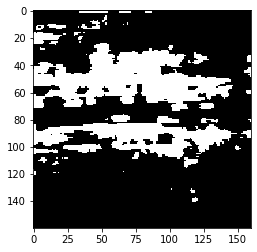

In [233]:
# free_class=np.rot90(free_class,2)
print(free_class.shape)
Nfree =free_class.copy()
print(Nfree.shape)
rotated_array = np.zeros_like(Nfree)

# Loop over each frame in the image array and rotate it by 180 degrees
for i in range(Nfree.shape[0]):
    rotated_array[i] = np.rot90(Nfree[i], 1)
    
    
plt.imshow(rotated_array[379])

In [225]:
import numpy as np
from scipy.interpolate import griddata

# Generate a sample polar grid
polar_image = actual_range_free
output_size =(160,160)
cart_image = np.zeros((2093,160,160))

# Define the x, y coordinates of the target Cartesian grid
x = np.linspace(-40, 40, 160)
y = np.linspace(-40, 40, 160)
X, Y = np.meshgrid(x, y)

# Define the x, y coordinates of the source polar grid
r = np.linspace(0, 40 * np.sqrt(2), 566)
theta = np.linspace(-np.pi, np.pi, 360)
theta_grid, r_grid = np.meshgrid(theta, r)


# # Perform nearest neighbor interpolation
# cartesian_grid = griddata((theta_grid.flatten(), r_grid.flatten()), polar_grid.flatten(), ((X.flatten(), Y.flatten())), method='nearest')
# cartesian_grid = cartesian_grid.reshape((160, 160))
for fr in range(frames):
    for i in range(output_size[0]):
        for j in range(output_size[1]):
        # Calculate the corresponding polar coordinates
            theta_curr = np.arctan2(y[j], x[i])
            r_curr = np.sqrt(x[i]**2 + y[j]**2)
        
        # Find the closest indices in the input polar image
            theta_idx = np.argmin(np.abs(theta - theta_curr))
            r_idx = np.argmin(np.abs(r - r_curr))
        
        # Set the pixel value using nearest neighbor interpolation
            cart_image[fr,i, j] = polar_image[fr,r_idx, theta_idx]


(2093, 160, 160)
(2093, 160, 160)


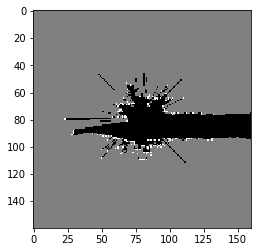

In [229]:
print(cart_image.shape)
print(free_class.shape)
plt.imshow(cart_image[1200])

In [218]:
for fr in range(frames):
    for i in range(160):
        for j in range(160):
            # Check if the pixel value is 0
            if cart_image[fr,i,j] == 1:
                # Set the pixel value to the corresponding value in free_class
                cart_image[fr,i,j] = rotated_array[fr,i,j]

1.0 0.0


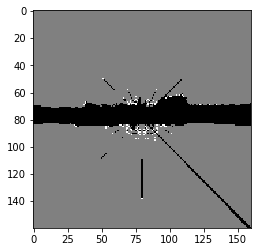

In [221]:
Semseg_map = cart_image.copy()

plt.imshow(Semseg_map[2])
print(NewS1.max(),NewS1.min())

In [226]:
hDF5_PATH = r'C:\Users\bjqb7h\Downloads\Thesis2022\Semseg Images'
with h5py.File(hDF5_PATH+'/'+ log+'SemsegV7'+'.hdf5', 'w') as hf:
        grp = hf.create_group(log)
        dataset = grp.create_dataset('Image data', data=cart_image) 

In [438]:
from skimage.filters import threshold_multiotsu
from skimage import filters

# thresholdsF = threshold_multiotsu(Semseg_map[:,:,:])
# thresholdsO = threshold_multiotsu(Semseg_map[:,:,:])
Freethresholds = filters.threshold_otsu(Semseg_map[:,:,:])
Occthresholds =filters.threshold_otsu(Semseg_map[:,:,:])

In [34]:
import numpy as np


# Convert pixels below threshold to black
black_pixels = NewS1 <= 0.3

# Convert pixels above threshold to white
white_pixels = NewS1 >= 0.7

# Convert pixels between (threshold, 1-threshold) to gray
gray_pixels = np.logical_and(NewS1 > 0.4, NewS1 < 0.6)


# Apply color codes to the three categories of pixels
NewS1[black_pixels] =255 # black
NewS1[white_pixels] =0  # white
NewS1[gray_pixels]  =127 # gray


NewS1 = NewS1.astype(np.float64)

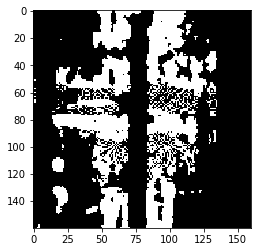

255.0 0.0


In [37]:
plt.imshow(NewS1, cmap='gray')
plt.show()
print(NewS1.max(),NewS1.min())


In [36]:
non_zero_pixels = np.where((NewS1 != 0) & (NewS1 != 255))

# Print the coordinates of the non-zero pixels
print(non_zero_pixels)

(array([], dtype=int64), array([], dtype=int64))


0.0 113.13708498984761


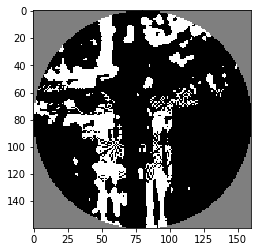

In [437]:
# Compute the distance of each pixel from the center
center = np.array(NewS1.shape) / 2
distances = np.sqrt(np.sum((np.indices(NewS1.shape).T - center)**2, axis=2))
print(distances.min(),distances.max())

# Threshold the distances to identify the pixels that are far from the center
unknown_pixels = distances > 80

# Assign gray color to the unknown pixels
NewS1[unknown_pixels] = 127

# Display the result
plt.imshow(NewS1, cmap='gray')
plt.show()

In [383]:
import numpy as np

# Define theta and range values
theta = np.linspace(-np.pi, np.pi, 360)


# Generate sample data for actual_range_occ and actual_range_free
frames = 2093


# Convert polar coordinates to cartesian coordinates for occupied class
x_occ = np.zeros((frames, 360))
y_occ = np.zeros((frames, 360))
for i in range(frames):
    actual_range_frame = actual_range_occ[i]
    x_frame = actual_range_frame * np.cos(theta)
    y_frame = actual_range_frame * np.sin(theta)
    x_occ[i] = x_frame
    y_occ[i] = y_frame

# Convert polar coordinates to cartesian coordinates for free class
x_free = np.zeros((frames, 360))
y_free = np.zeros((frames, 360))
for i in range(frames):
    actual_range_frame = actual_range_free[i]
    x_frame = actual_range_frame * np.cos(theta)
    y_frame = actual_range_frame * np.sin(theta)
    x_free[i] = x_frame
    y_free[i] = y_frame

print(x_occ.shape,x_free.shape)

ValueError: could not broadcast input array from shape (566,360) into shape (360,)

In [66]:
from scipy.interpolate import interp1d

# x_occ and y_occ have shape (2093, 360)
new_x_occ = np.zeros((2093, 160))
new_y_occ = np.zeros((2093, 160))

# Define the range of x values for interpolation
x_range = np.linspace(-40, 40, 360)

# Loop over all frames
for i in range(2093):
    # Interpolate x_occ and y_occ to get 160 evenly spaced points
    f_x = interp1d(x_range, x_occ[i,:], kind='cubic')
    f_y = interp1d(x_range, y_occ[i,:], kind='cubic')
    new_x_occ[i,:] = f_x(np.linspace(-40, 40, 160))
    new_y_occ[i,:] = f_y(np.linspace(-40, 40, 160))

print(new_x_occ.shape,new_y_occ.shape,x_range.shape)
# new_x_occ and new_y_occ now have shape (2093, 160)
resolution = 0.5
x_occ_discrete = new_x_occ/ resolution
y_occ_discrete = new_y_occ / resolution

(2093, 160) (2093, 160) (360,)


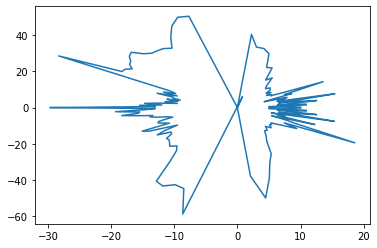

In [30]:
plt.plot(x_occ_discrete[1],y_occ_discrete[1])


In [622]:
import numpy as np

# Assuming you have already defined x_occ_disc and y_occ_disc with shape (2093, 160)
image_array = np.zeros((2093, 160, 160))

for i in range(2093):
    for j in range(160):
        for k in range(160):
            dist = np.sqrt((x_occ_discrete[i][j]-k)**2 + (y_occ_discrete[i][j]-k)**2)
            if dist <= 0.5:
                image_array[i][j][k] = 1.0


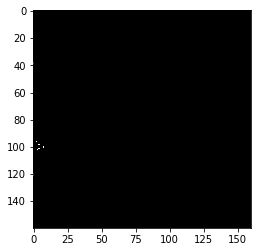

In [623]:
plt.imshow(image_array[1])

In [529]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
rng = np.random.default_rng()
points = rng.random((1000,2))
values = func(points[:,0], points[:,1])
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')

print(grid_x.shape)
print(grid_y.shape)
print(xx.shape)
print(yy.shape)
print(points.shape)
print(values.shape)
print(grid_z0.shape)
points = np.stack((x_occ[1], y_occ[1]))
points = np.transpose(points)
print(points.shape)

(100, 200)
(100, 200)
(160, 160)
(160, 160)
(1000, 2)
(1000,)
(100, 200)
(360, 2)


In [585]:
import numpy as np
from scipy import interpolate

# Generate some example data
A = np.random.rand(360)
n_points = 160

# Define the new x-axis
new_x = np.linspace(0, 359, n_points)

# Create the interpolation function
f = interpolate.interp1d(np.arange(360), A, kind='linear')

# Interpolate the data to the new x-axis
B = f(new_x)

print(B.shape)

(160,)


In [593]:
import numpy as np
from scipy.interpolate import interp1d


# Define the new number of data points
n_points = 160

# Create new arrays with the desired number of data points
new_x = np.linspace(-40, +40, n_points)
new_y = np.linspace(-40, +40, n_points)

# # Initialize arrays to hold the interpolated data
# x_new = np.zeros((2093, n_points))
# y_new = np.zeros((2093, n_points))

print(x_new.shape)

# Perform interpolation for each frame
for i in range(2093):
    f_x = interp1d(np.arange(360), x_occ[i], kind='nearest')
    f_y = interp1d(np.arange(360), y_occ[i], kind='nearest')
    new_x = np.linspace(x_occ[i].min(),x_occ[i].max(), n_points)
    x_new = f_x(new_x)
    y_new = f_y(new_y)


(2093, 160)


ValueError: A value in x_new is below the interpolation range.

In [551]:
print(interp_values_x[1])

[-7.1989     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan   

In [437]:
# assuming x_occ, y_occ, x_free, and y_free are already defined
frames = x_occ.shape[0]

# create 2D grid of coordinates
xx, yy = np.meshgrid(np.arange(160), np.arange(160))
xx = xx.flatten()
yy = yy.flatten()

# initialize image array
image_data = np.zeros((frames, 160, 160))

for i in range(frames):
    distance_occ = np.sqrt((xx - x_occ[i])**2 + (yy - y_occ[i])**2)
    image_data[i][distance_occ.reshape(160, 160) < actual_range_occ[i]] = 1
    
    distance_free = np.sqrt((xx - x_free[i])**2 + (yy - y_free[i])**2)
    image_data[i][distance_free.reshape(160, 160) < actual_range_free[i]] = 2

ValueError: operands could not be broadcast together with shapes (25600,) (360,) 

In [313]:

# Create a new array to hold the merged data
actual_range_combined = np.zeros((2093, 360))

# Find the maximum value at each index
actual_range_combined = np.where(actual_range_occ > actual_range_free, actual_range_occ, actual_range_free)

In [404]:
x_occ = np.zeros((frames, 360))
y_occ = np.zeros((frames, 360))
theta_space = np.linspace(-np.pi, np.pi, 360)

for i in range(frames):
    actual_range_frame = actual_range_occ[i]
    x_frame = actual_range_frame * np.cos(theta_space)
    y_frame = actual_range_frame * np.sin(theta_space)
    x_occ[i] = x_frame
    y_occ[i] = y_frame

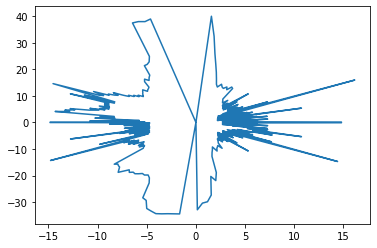

In [383]:
plt.plot(x_occ[40],y_occ[40])

In [385]:


import numpy as np
from scipy.interpolate import interp1d

# Assuming x_occ and y_occ are already calculated with shape (2093, 360)

theta_orig = np.linspace(-np.pi, np.pi, 360)
theta_interp = np.linspace(-np.pi, np.pi, 160)

x_occ_2d = np.zeros((2093, 160))
y_occ_2d = np.zeros((2093, 160))

for i in range(2093):
    f_x = interp1d(theta_orig, x_occ[i], kind='cubic')
    f_y = interp1d(theta_orig, y_occ[i], kind='cubic')
    x_occ_2d[i] = f_x(theta_interp)
    y_occ_2d[i] = f_y(theta_interp)


In [324]:
# from scipy.interpolate import interp1d

# # Assuming x_occ and y_occ are of shape (2093, 360)
# x_interp = interp1d(np.arange(360), x_occ, axis=-1)(np.linspace(0, 359, 160))
# y_interp = interp1d(np.arange(360), y_occ, axis=-1)(np.linspace(0, 359, 160))

(160,)


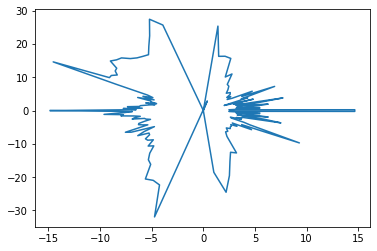

In [387]:
plt.plot(x_occ_2d[2],y_occ_2d[2])
print(x_occ_2d[2].shape)